# init

In [1]:
import os
import numpy as np
import PIL
from PIL import Image
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms
import torch
from torch import nn
from torch.nn import functional as F
from typing import List, Callable, Union, Any, TypeVar, Tuple
from torch import tensor as Tensor
from tqdm import tqdm
from torchinfo import summary
import wandb
import glob

In [2]:
import wandb
import time
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)


# model

In [3]:
##https://github.com/AntixK/PyTorch-VAE/blob/master/models/vanilla_vae.py
# Tensor = TypeVar('torch.tensor')


class VanillaVAE(nn.Module):


    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        # print()
        self.fc_mu = nn.Linear(hidden_dims[-1]*8*8, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*8*8, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] *8*8)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 1,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)
        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result) #  nn.Linear
        log_var = self.fc_var(result) # nn.Linear

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        # print(result.shape)
        result = result.view(-1, 512, 8,8)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

## v2
conv2d mid layer  
add groupnorm 32


In [4]:
def Normalize(in_channels, num_groups=32):
    return torch.nn.GroupNorm(num_groups=num_groups, num_channels=in_channels, eps=1e-6, affine=True)
class AttnBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels

        self.norm = Normalize(in_channels)
        self.q = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.k = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.v = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.proj_out = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=1,
                                        stride=1,
                                        padding=0)


    def forward(self, x):
        h_ = x
        h_ = self.norm(h_)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)

        # compute attention
        b,c,h,w = q.shape
        q = q.reshape(b,c,h*w)
        q = q.permute(0,2,1)   # b,hw,c
        k = k.reshape(b,c,h*w) # b,c,hw
        w_ = torch.bmm(q,k)     # b,hw,hw    w[b,i,j]=sum_c q[b,i,c]k[b,c,j]
        w_ = w_ * (int(c)**(-0.5))
        w_ = torch.nn.functional.softmax(w_, dim=2)

        # attend to values
        v = v.reshape(b,c,h*w)
        w_ = w_.permute(0,2,1)   # b,hw,hw (first hw of k, second of q)
        h_ = torch.bmm(v,w_)     # b, c,hw (hw of q) h_[b,c,j] = sum_i v[b,c,i] w_[b,i,j]
        h_ = h_.reshape(b,c,h,w)

        h_ = self.proj_out(h_)

        return x+h_

In [5]:


class VanillaVAE_v2(nn.Module):


    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(VanillaVAE_v2, self).__init__()

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    Normalize(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.mid_params = nn.Conv2d(hidden_dims[-1],latent_dim*2,1)
        self.decoder_input2 = nn.Conv2d(latent_dim, hidden_dims[-1],1)

        hidden_dims.reverse()
            # Build Decoder
        modules = []
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    Normalize(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )
        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            Normalize(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 1,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = self.mid_params(result)
        mu,log_var = torch.chunk(result,2,dim=1)
        # Split the result into mu and var components
        # of the latent Gaussian distribution

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input2(z)

        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        # print("input,decode(z),mu,var,z",input.shape,self.decode(z).shape,mu.shape,log_var.shape,z.shape)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)

        # kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
        kld_loss = torch.mean(-0.5 * torch.sum(-torch.pow(mu, 2)
                                       - log_var.exp() + 1.0 + log_var,
                                       dim=[1, 2, 3]),dim=0)
        loss = recons_loss + kld_weight * kld_loss
        # print(log_var.shape,mu.shape,torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1).shape,kld_loss.shape)
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

## ConvAE

In [6]:
class ConvAE(nn.Module):


    def __init__(self,
                 in_channels: int,
                #  latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(ConvAE, self).__init__()

        # self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 1, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(),
                    nn.MaxPool2d(2,2)),
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        # print()
        # self.fc_mu = nn.Linear(hidden_dims[-1]*8*8, latent_dim)
        # self.fc_var = nn.Linear(hidden_dims[-1]*8*8, latent_dim)


        # Build Decoder
        modules = []

        # self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] *8*8)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 1,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        # print(input.shape)
        result = self.encoder(input)
        # print(result.shape)

        return result

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """

        result = self.decoder(z)
        result = self.final_layer(result)
        return result

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        return [self.decode(self.encode(input)),input]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = torch.unsqueeze(args[1][:,0],1)
        loss =F.mse_loss(recons,input)
        # print(args[0].shape,args[1].shape,input.shape)
        return {'loss': loss}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

# dataset

In [7]:
IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def make_dataset(dir):
    print(os.path.isfile(dir))
    if os.path.isfile(dir):
        arr = np.genfromtxt(dir, dtype=str, encoding='utf-8')
        if arr.ndim:
            images = [i for i in arr]
        else:
            images = np.array([arr])
    else:
        images = []
        assert os.path.isdir(dir), '%s is not a valid directory' % dir
        for root, _, fnames in sorted(os.walk(dir)):
            for fname in sorted(fnames):
                if is_image_file(fname):
                    path = os.path.join(root, fname)
                    images.append(path)

    return images


class PPG2ABPDataset_v3_base(Dataset):
    def __init__(self,data_flist,data_root = r"F:\minowa\BloodPressureEstimation\data\processed\BP_npy\0325_256_corr_clean\p00",
                 data_len=1000, size=224, loader=None):
        self.data_root = data_root
        self.data_flist = data_flist
        self.flist = make_dataset(self.data_flist)
        # if data_len > 0:
        #     self.flist = flist[:int(data_len)]
        # else:
        #     self.flist = flist
        self.tfs = transforms.ToTensor()
        self.size = size
        self.data=self.load_npys()
        if data_len > 0:
            data_index = np.arange(0,len(self.data),max(len(self.data)//int(data_len),0)).astype(int)[:int(data_len)]
            self.data = self.data[data_index]
        else:
            self.data = self.data[:len(self.data)-len(self.data)%64]
        print("data prepared:" ,self.data.shape)
    # def _expand_dims(self,tensor):
    #     length = tensor.shape[-1]
    #     reshaped = torch.unsqueeze(tensor, axis=2)
    #     reshaped = torch.repeat_interleave(reshaped, length, axis=2)
    #     return reshaped
    def load_npys(self):
        data = []
        for f in self.flist:
            arr = np.load(self.data_root+"\\"+str(f))
            if len(arr) != 0:
                data.append(arr)
        data = np.concatenate(data)
        return data
    
    def __getitem__(self, index):
        # ret = {}
        # ret['gt_image'] = self._expand_dims(torch.from_numpy(self.data[index,:,0].astype(np.float32)))
        # ret['cond_image'] = self._expand_dims(torch.from_numpy(self.data[index,:,1].astype(np.float32)))
        ret = self.data[index,:,1].astype(np.float32)
        ret = np.tile(ret,(256,1))[np.newaxis]
        # ret['path'] = str(index)
        return ret

    def __len__(self):
        return self.data.shape[0]
    
class PPG2ABPDataset_v3_Train(PPG2ABPDataset_v3_base):
    def __init__(self, data_len=-1, size=224, loader=None):
        super().__init__(data_flist = r"F:\minowa\BloodPressureEstimation\data\processed\list\train_BP2.txt",data_len=data_len,size=size)

class PPG2ABPDataset_v3_Val(PPG2ABPDataset_v3_base):
    def __init__(self, data_len=-1, size=224, loader=None):
        super().__init__(data_flist = r"F:\minowa\BloodPressureEstimation\data\processed\list\val_BP2.txt",data_len=data_len,size=size)

class PPG2ABPDataset_v3_Test(PPG2ABPDataset_v3_base):
    def __init__(self, data_len=-1, size=224, loader=None):
        super().__init__(data_flist = r"F:\minowa\BloodPressureEstimation\data\processed\list\test_BP2.txt",data_len=data_len,size=size)         
    

# v4
multi channel input

In [8]:
class PPG2ABPDataset_v4_base(Dataset):
    def __init__(self,data_flist,data_root = r"..\data\processed\BP_npy\0625_256_2_diff_clean\p00",
                 data_len=1000, size=224, loader=None, use_ppg = False):
        self.data_root = data_root
        self.data_flist = data_flist
        self.flist = make_dataset(self.data_flist)
        # if data_len > 0:
        #     self.flist = flist[:int(data_len)]
        # else:
        #     self.flist = flist
        self.use_ppg = int(use_ppg)
        self.tfs = transforms.ToTensor()
        self.size = size
        self.data=self.load_npys()
        if data_len > 0:
            data_index = np.arange(0,len(self.data),max(len(self.data)//int(data_len),0)).astype(int)[:int(data_len)]
            self.data = self.data[data_index]
        else:
            self.data = self.data[:len(self.data)-len(self.data)%64]
        print("data prepared:" ,self.data.shape)
    def load_npys(self):
        data = []
        i = self.use_ppg
        for f in self.flist:
            arr = np.load(self.data_root+"\\"+str(f))[:,:,i]
            arr = arr.squeeze().transpose(0,2,1) # (-1, 256,  3) -> (-1, 3, 256)
            if len(arr) != 0:
                data.append(arr)
        data = np.concatenate(data)
        return data
    
    def __getitem__(self, index):
        ret = self.data[index].astype(np.float32) # (3,256)
        ret = np.tile(ret[:, np.newaxis, :], (1, 256, 1)) # (-1, 3, 256, 256)
        return ret

    def __len__(self):
        return self.data.shape[0]
    
class PPG2ABPDataset_v4_Train(PPG2ABPDataset_v4_base):
    def __init__(self, data_len=-1, size=224, loader=None,use_ppg=False):
        super().__init__(data_flist = r"..\data\processed\list\train_BP2.txt",data_len=data_len,size=size,use_ppg=use_ppg)

class PPG2ABPDataset_v4_Val(PPG2ABPDataset_v4_base):
    def __init__(self, data_len=-1, size=224, loader=None,use_ppg=False):
        super().__init__(data_flist = r"..\data\processed\list\val_BP2.txt",data_len=data_len,size=size,use_ppg=use_ppg)

class PPG2ABPDataset_v4_Test(PPG2ABPDataset_v4_base):
    def __init__(self, data_len=-1, size=224, loader=None,use_ppg=False):
        super().__init__(data_flist = r"..\data\processed\list\test_BP2.txt",data_len=data_len,size=size,use_ppg=use_ppg)         
    

# train function

In [9]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model,epoch):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model,epoch)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model,epoch)
            self.counter = 0

    def save_checkpoint(self, val_loss, model,epoch):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path.format(t=epoch))
        self.val_loss_min = val_loss

## train

In [10]:
def train(dataloader,optimizer, model,kld_weight=0.00025):
    # optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    size = len(dataloader.dataset)
    total_loss_sum=0
    recon_loss_sum=0
    kld_loss_sum = 0
    total=0
    with tqdm(total=len(dataloader),unit="batch") as pbar:
        # with torch.autograd.set_detect_anomaly(True):
        for batch, X in enumerate(dataloader):
            X = X.to(device)
            
            # print(X.shape)
            # print(X.shape,y.shape)
            # Compute prediction error
            results = model.forward(X)
            optimizer.zero_grad()
            loss = model.loss_function(*results, M_N=kld_weight)
            
            # Backpropagation
            total+=X.size(0)
            # {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}
            total_loss_sum+=loss['loss']*X.size(0) 
            # recon_loss_sum+=loss['Reconstruction_Loss']*X.size(0) 
            # kld_loss_sum+=loss['KLD']*X.size(0)
            running_total_loss=total_loss_sum/total
            # running_recon_loss=recon_loss_sum/total
            # running_kld_loss=kld_loss_sum/total
            loss['loss'].backward()
            # print(X.grad)
            optimizer.step()
            metrics = {"train/total_loss_batch":loss['loss'].item(),
                    #    "train/recon_loss_batch":loss['Reconstruction_Loss'].item(),
                    #    "train/KLD_batch":loss['KLD'].item(),
                       "train/total_loss":running_total_loss.item(),
                    #    "train/recon_loss(MSE)":running_recon_loss.item(),
                    #    "train/KLD":running_kld_loss.item(),
                    #    "Total":total
                       }
            if batch < 100:
                # 🐝 Log train metrics to wandb 
                wandb.log(metrics)
            # if batch < 50:
                # wandb.log(metrics)
                # torch.save(model.state_dict(),"./wandb/weights.pth")
                # artifact = wandb.Artifact('model-weights',type='weights')
                # artifact.add_file("./wandb/weights.pth")
                # wandb.log_artifact(artifact)
                # time.sleep(10)
            pbar.set_postfix(metrics)
            pbar.update(1)
    return total

## test

In [11]:
def test(dataloader, model, log_images=2,kld_weight=0.00025,save = False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    total=0
    test_total_loss_sum=0
    test_recon_loss_sum=0
    test_kld_loss_sum = 0
    images = []
    gt = []
    log_arr = np.random.randint(0,num_batches)
    with torch.no_grad():
        for i,X in enumerate(dataloader):
            X = X.to(device)
            total+=X.size(0)
            # print("x",X.shape)
            results = model.forward(X)
            loss = model.loss_function(*results, M_N=kld_weight)
            if save:
                images.append(model.generate(X).detach().cpu().numpy())
                gt.append(X.detach().cpu().numpy())
            test_total_loss_sum+=loss['loss']*X.size(0) 
            # test_recon_loss_sum+=loss['Reconstruction_Loss']*X.size(0) 
            # test_kld_loss_sum+=loss['KLD']*X.size(0)
            if i == log_arr: 
                pred = model.generate(X)
                print(pred.shape)
                pred_image = wandb.Image(pred[0].detach().permute(1,2,0).cpu().numpy(),mode='L', caption=f"generated {i*X.shape[0]}")
                gt_image = wandb.Image(X[0].detach().permute(1,2,0).cpu().numpy(),mode='RGB', caption=f"ground truth {i*X.shape[0]}")
                wandb.log({"val/pred_image":pred_image,"val/gt_image":gt_image})
    test_total_loss_sum /= total
    # test_recon_loss_sum /= total
    # test_kld_loss_sum /= total
    wandb.log({"val/total_loss":test_total_loss_sum.item(),
                    #    "val/recon_loss(MSE)":test_recon_loss_sum.item(),
                    #    "val/KLD":test_kld_loss_sum.item(),
                       })
    # print(f"Test Error: {test_total_loss_sum.item():>8f}\nMSE: {test_recon_loss_sum.item():>8f} \nKLD: {test_kld_loss_sum.item():>8f} \n")
    if save:
        images = np.concatenate(images,axis=0)
        gt = np.concatenate(gt,axis=0)
    return test_total_loss_sum.item(),[images,gt]

# run

In [12]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 24amj35 (bsa_mh). Use `wandb login --relogin` to force relogin


True

In [13]:
# del model
# import gc
# gc.collect()

In [14]:
# model = VanillaVAE_v2(in_channels = 1, latent_dim=4,hidden_dims=[64,128,256,512]).to(device)
use_ppg = True
model = ConvAE(in_channels = 3,hidden_dims=[64,128,256]).to(device)
# model = VanillaVAE(in_channels = 1, latent_dim=32).to(device)
train_loader = torch.utils.data.DataLoader(dataset=PPG2ABPDataset_v4_Train(data_len=30000,use_ppg=use_ppg), 
                                         batch_size=16, 
                                         shuffle=True, )
val_loader = torch.utils.data.DataLoader(dataset=PPG2ABPDataset_v4_Val(data_len=1000,use_ppg=use_ppg), 
                                         batch_size=16, 
                                         shuffle=False, )
test_loader = torch.utils.data.DataLoader(dataset=PPG2ABPDataset_v4_Test(data_len=2000,use_ppg=use_ppg), 
                                          batch_size=16, 
                                         shuffle=False, )


True
data prepared: (30000, 3, 256)
True
data prepared: (1000, 3, 256)
True
data prepared: (2000, 3, 256)


In [15]:
path = os.path.join(".\outputs\\0625_vae_bp\\{t}.pth")
kld_weight = 32/(256**2) # 
epochs = 100
lr = 0.0001
kld_weight


0.00048828125

In [16]:
wandb.init(
    # set the wandb project where this run will be logged
    project="VAE",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "VanillaVAE_v2",
    "dataset": "bpdataset_bp" if use_ppg else 'bpdataset_bp',
    "epochs": epochs,
    }
)
wandb.watch(model, log_freq=100)


[]

In [17]:
print(kld_weight)
model_summary = summary(model,input_size=[16,3,256,256])
print(model_summary)

0.00048828125
Layer (type:depth-idx)                   Output Shape              Param #
ConvAE                                   [16, 1, 256, 256]         --
├─Sequential: 1-1                        [16, 256, 32, 32]         --
│    └─Sequential: 2-1                   [16, 64, 128, 128]        --
│    │    └─Conv2d: 3-1                  [16, 64, 256, 256]        1,792
│    │    └─BatchNorm2d: 3-2             [16, 64, 256, 256]        128
│    │    └─LeakyReLU: 3-3               [16, 64, 256, 256]        --
│    │    └─MaxPool2d: 3-4               [16, 64, 128, 128]        --
│    └─Sequential: 2-2                   [16, 128, 64, 64]         --
│    │    └─Conv2d: 3-5                  [16, 128, 128, 128]       73,856
│    │    └─BatchNorm2d: 3-6             [16, 128, 128, 128]       256
│    │    └─LeakyReLU: 3-7               [16, 128, 128, 128]       --
│    │    └─MaxPool2d: 3-8               [16, 128, 64, 64]         --
│    └─Sequential: 2-3                   [16, 256, 32, 32]    

In [18]:

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

early_stopping = EarlyStopping(patience=10, verbose=True,path=path,delta=0.0002)
os.makedirs(os.path.dirname(path),exist_ok=True)
try:
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        # train(train_dataloader, model, loss_fn,loss_mae, optimizer)
        train(train_loader, optimizer,model,kld_weight=kld_weight)
        val_loss,_ = test(val_loader, model,kld_weight=kld_weight)
        early_stopping(val_loss, model,t)

        if early_stopping.early_stop:
            print("Early stopping")
            break
        # if t % 5 ==0: 
            # torch.save(model.state_dict(),path.format(t=t))
except KeyboardInterrupt:
    torch.save(model.state_dict(),path.format(t="latest"))
finally:
    torch.save(model.state_dict(),path.format(t="latest"))
# load best epoch

paths = glob.glob(os.path.join(os.path.dirname(path),"[0-9]*.pth"))
best_epoch = sorted([int(os.path.splitext(os.path.basename(p))[0]) for p in paths])[-1]
print('best epoch is epoch',best_epoch)
model.load_state_dict(torch.load(path.format(t=best_epoch)))
loss, images = test(test_loader,model,kld_weight=kld_weight,save=True)
print(images[0].shape,images[1].shape)
images[0] = images[0].squeeze()
images[1] = images[1].squeeze()
np.savez(os.path.join(os.path.dirname(path),'output.npz'),out=images[0],gt=images[1])
wandb.finish()
loss


Epoch 1
-------------------------------


100%|██████████| 1875/1875 [03:40<00:00,  8.50batch/s, train/total_loss_batch=0.000145, train/total_loss=0.00116]


torch.Size([16, 1, 256, 256])
Validation loss decreased (inf --> 0.000074).  Saving model ...
Epoch 2
-------------------------------


100%|██████████| 1875/1875 [03:31<00:00,  8.87batch/s, train/total_loss_batch=1.46e-5, train/total_loss=2.27e-5]


torch.Size([16, 1, 256, 256])
EarlyStopping counter: 1 out of 10
Epoch 3
-------------------------------


100%|██████████| 1875/1875 [03:31<00:00,  8.87batch/s, train/total_loss_batch=6.35e-6, train/total_loss=1.44e-5]


torch.Size([16, 1, 256, 256])
EarlyStopping counter: 2 out of 10
Epoch 4
-------------------------------


100%|██████████| 1875/1875 [03:27<00:00,  9.03batch/s, train/total_loss_batch=1.26e-5, train/total_loss=1.12e-5]


torch.Size([16, 1, 256, 256])
EarlyStopping counter: 3 out of 10
Epoch 5
-------------------------------


100%|██████████| 1875/1875 [03:27<00:00,  9.04batch/s, train/total_loss_batch=1.18e-5, train/total_loss=8.46e-6] 


torch.Size([16, 1, 256, 256])
EarlyStopping counter: 4 out of 10
Epoch 6
-------------------------------


100%|██████████| 1875/1875 [03:27<00:00,  9.04batch/s, train/total_loss_batch=2.51e-6, train/total_loss=7.16e-6]


torch.Size([16, 1, 256, 256])
EarlyStopping counter: 5 out of 10
Epoch 7
-------------------------------


100%|██████████| 1875/1875 [03:27<00:00,  9.04batch/s, train/total_loss_batch=2.19e-5, train/total_loss=6.04e-6]


torch.Size([16, 1, 256, 256])
EarlyStopping counter: 6 out of 10
Epoch 8
-------------------------------


100%|██████████| 1875/1875 [03:27<00:00,  9.06batch/s, train/total_loss_batch=2.57e-6, train/total_loss=5.12e-6]


torch.Size([16, 1, 256, 256])
EarlyStopping counter: 7 out of 10
Epoch 9
-------------------------------


100%|██████████| 1875/1875 [03:25<00:00,  9.11batch/s, train/total_loss_batch=1.79e-6, train/total_loss=4.81e-6]


torch.Size([16, 1, 256, 256])
EarlyStopping counter: 8 out of 10
Epoch 10
-------------------------------


100%|██████████| 1875/1875 [03:25<00:00,  9.11batch/s, train/total_loss_batch=2.2e-6, train/total_loss=3.96e-6] 


torch.Size([16, 1, 256, 256])
EarlyStopping counter: 9 out of 10
Epoch 11
-------------------------------


100%|██████████| 1875/1875 [03:25<00:00,  9.11batch/s, train/total_loss_batch=1.36e-6, train/total_loss=3.79e-6]


torch.Size([16, 1, 256, 256])
EarlyStopping counter: 10 out of 10
Early stopping
best epoch is epoch 0
torch.Size([16, 1, 256, 256])
(2000, 1, 256, 256) (2000, 3, 256, 256)


train/total_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss_batch,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/total_loss,█▂▂▂▂▁▂▁▁▁▁█
train/total_loss,0.0
train/total_loss_batch,0.0
val/total_loss,7e-05


6.95542839821428e-05

# test

In [19]:
i  =iter(test_loader)
x = i.__next__()
x.shape


torch.Size([16, 3, 256, 256])

In [20]:
from PIL import Image, ImageFilter
def im(arr):
 return Image.fromarray(((arr[0]+1)*255).detach().cpu().numpy().astype(np.uint8).squeeze())


In [32]:
arr = np.load(r"F:\minowa\BloodPressureEstimation\data\processed\BP_npy\0325_256_corr_clean\p00\validate.npy")[2,:,0]
ret = np.tile(arr,(256,1))[np.newaxis].squeeze()
ret.shape

(256, 256)

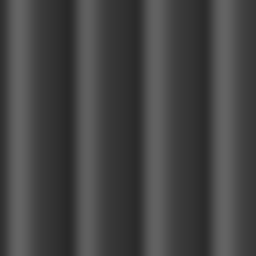

In [33]:
Image.fromarray(((ret+1)*255).astype(np.uint8).squeeze())

In [9]:
im(x)

TypeError: Cannot handle this data type: (1, 1, 256), |u1

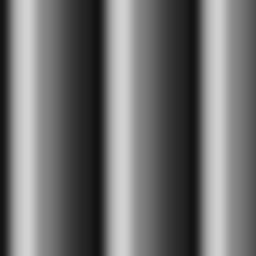

In [ ]:
im(model.generate(x.to(device)))

(<PIL.Image.Image image mode=L size=256x256>,
 <PIL.Image.Image image mode=L size=256x256>)